In [6]:
import os, sys, glob, re
import datetime as dt
import numpy as np
from calendar import monthrange
from matplotlib.dates import date2num, num2date
import h5py
from sklearn import decomposition
import nimfa

sys.path.insert(0,'/home/wu-jung/code_git/mi-instrument')
from mi.instrument.kut.ek60.ooicore.zplsc_b import *
# from concat_raw import get_num_days_pings, get_data_from_h5
# from echogram_decomp import find_nearest_time_idx,reshape_into_3freq,reshape_into_1freq,\
#     sep_into_freq,plot_decomp_v,plot_decomp_transform
from db_diff import *

import matplotlib.pyplot as plt
from modest_image import imshow
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
%matplotlib inline

In [8]:
year_all = 2015
month_all = 9
day_all = range(20,31)
month_all = (month_all,) if not isinstance(month_all, (tuple, list)) else month_all
year_all = (year_all,) if not isinstance(year_all, (tuple, list)) else year_all
date_wanted = ['%04d%02d%02d' %(yy,mm,dd) for dd in day_all for mm in month_all for yy in year_all]

In [9]:
date_wanted

['20150920',
 '20150921',
 '20150922',
 '20150923',
 '20150924',
 '20150925',
 '20150926',
 '20150927',
 '20150928',
 '20150929',
 '20150930']

In [10]:
data_path = '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/'

In [11]:
files = glob.glob(os.path.join(data_path,'OOI-D%s*.raw' %date_wanted[0]))

## Load data

In [309]:
particle_data, data_times, power_data_dict, freq, bin_size, config_header, config_transducer = parse_echogram_file(files[0])

2017-10-11 03:05:52,369 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20150920-T000000.raw'


In [310]:
cal_params = get_cal_params(power_data,particle_data,config_header,config_transducer)

In [312]:
# Swap sequence of 120 kHz and 38 kHz cal_params and data
cal_params = [cal_params[fn] for fn in [1,0,2]]
power_data = get_power_data_mtx(power_data_dict,freq)

## Noise estimation and removal

In [433]:
# Set param
ping_bin_range = 40
depth_bin_range = 10
depth_bin_size = bin_size
tvg_correction_factor = 2

In [434]:
num_freq = len(power_data)
fn=0
Sv_raw = np.ma.empty((num_freq,power_data[1].shape[0],power_data[1].shape[1]))
Sv_corr = np.ma.empty((num_freq,power_data[1].shape[0],power_data[1].shape[1]))
Sv_noise = np.ma.empty((num_freq,power_data[1].shape[0],power_data[1].shape[1]))
for fn in range(num_freq):
    noise_est,ping_bin_num = get_noise(power_data[fn,:,:],depth_bin_size,ping_bin_range,depth_bin_range)
    Sv_raw[fn,:,:],Sv_corr[fn,:,:],Sv_noise[fn,:,:] = \
            remove_noise(power_data[fn,:,:],cal_params[fn],noise_est,ping_bin_range,tvg_correction_factor)

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in log10


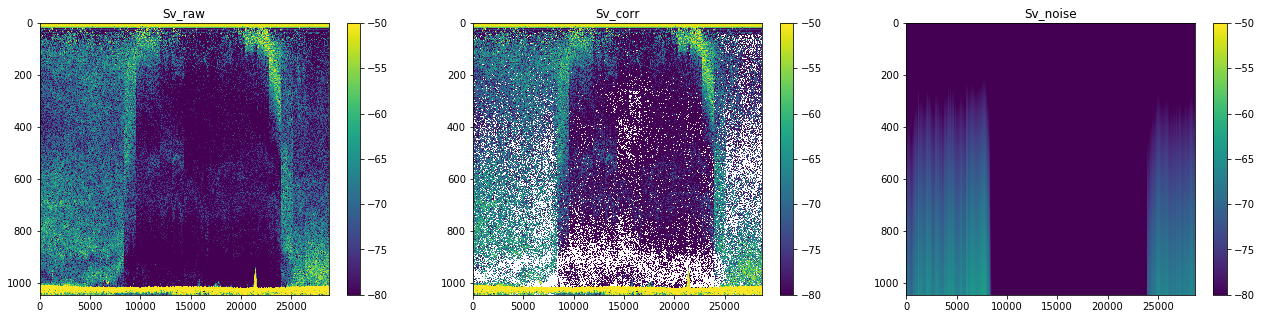

In [435]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_raw[0,:,:],aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Sv_raw')
im1 = ax1.imshow(Sv_corr[0,:,:],aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Sv_corr')
im2 = ax2.imshow(Sv_noise[0,:,:],aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Sv_noise')

## Select data wanted

In [437]:
def find_nearest_time_idx_new(all_timestamp_num,time_wanted,tolerance):
    '''
    Function to find nearest element
    time_wanted is a datetime object
    tolerance is the max tolerance in second allowed between `time_wanted` and `all_timestamp`
    all_timestamp_num is a numerical date object (i.e., output from `date2num`)
    '''
    time_wanted_num = date2num(time_wanted)
    idx = np.searchsorted(all_timestamp_num, time_wanted_num, side="left")
    if idx > 0 and (idx == len(all_timestamp_num) or \
        np.abs(time_wanted_num - all_timestamp_num[idx-1]) < np.abs(time_wanted_num - all_timestamp_num[idx])):
        idx -= 1

    # If interval between the selected index and time wanted > `tolerance` seconds
    sec_diff = dt.timedelta(all_timestamp_num[idx]-time_wanted_num).total_seconds()
    if np.abs(sec_diff)>tolerance:
        return np.nan
    else:
        return idx

In [520]:
dd = dt.datetime.strptime(date_wanted[0],'%Y%m%d')
hour_all = range(24)
min_all = range(20)
sec_all = range(0,60,1)

In [521]:
time_wanted = [dt.datetime(dd.year,dd.month,dd.day,hh,mm,ss) for hh in hour_all for mm in min_all for ss in sec_all]
idx_wanted = [find_nearest_time_idx_new(data_times,tt,2) for tt in time_wanted]

In [522]:
notnanidx = np.argwhere(~np.isnan(idx_wanted)).flatten()
notnanidx_in_all = np.array(idx_wanted)[notnanidx].astype(int)

In [523]:
Sv_raw_wanted = np.ma.empty((len(power_data),power_data[1].shape[0],len(time_wanted)))
Sv_corr_wanted = np.ma.empty((len(power_data),power_data[1].shape[0],len(time_wanted)))
Sv_raw_wanted[:,:,notnanidx] = Sv_raw[:,:,notnanidx_in_all]
Sv_corr_wanted[:,:,notnanidx] = Sv_corr[:,:,notnanidx_in_all]

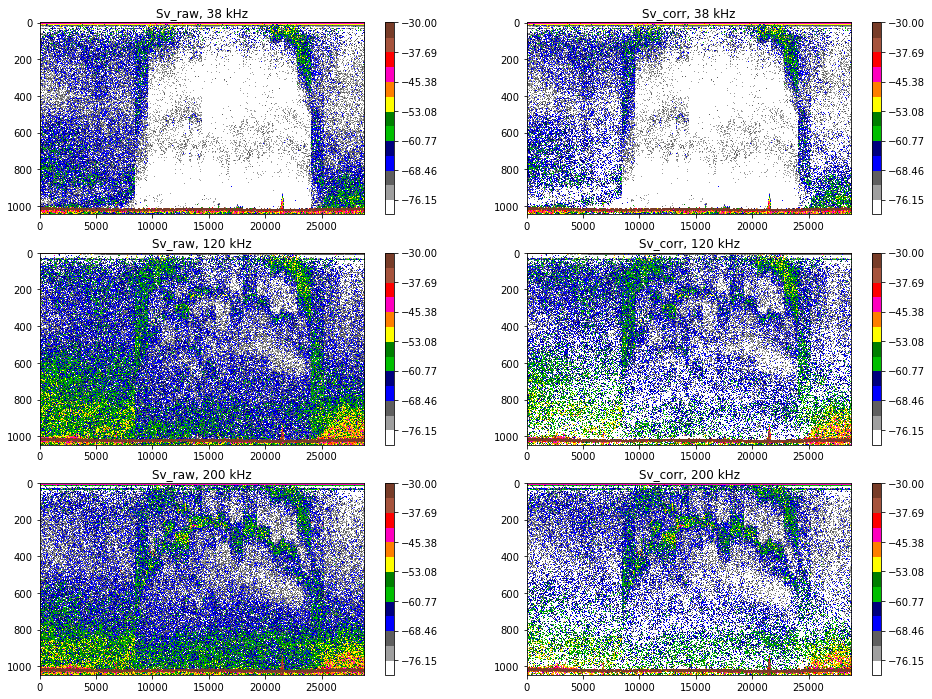

In [535]:
fig,ax = plt.subplots(3,2,figsize=(16,12))
im0 = ax[0,0].imshow(Sv_raw_wanted[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im0,ax=ax[0,0])
ax[0,0].set_title('Sv_raw, 38 kHz')
im1 = ax[0,1].imshow(Sv_corr_wanted[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im1,ax=ax[0,1])
ax[0,1].set_title('Sv_corr, 38 kHz')
im2 = ax[1,0].imshow(Sv_raw_wanted[1,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im2,ax=ax[1,0])
ax[1,0].set_title('Sv_raw, 120 kHz')
im3 = ax[1,1].imshow(Sv_corr_wanted[1,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im3,ax=ax[1,1])
ax[1,1].set_title('Sv_corr, 120 kHz')
im4 = ax[2,0].imshow(Sv_raw_wanted[2,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im4,ax=ax[2,0])
ax[2,0].set_title('Sv_raw, 200 kHz')
im5 = ax[2,1].imshow(Sv_corr_wanted[2,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im5,ax=ax[2,1])
ax[2,1].set_title('Sv_corr, 200 kHz')

## Obtain MVBS

In [525]:
def get_MVBS(Sv,depth_bin_size,ping_bin_range,depth_bin_range):
    '''
    Obtain mean MVBS
    
    INPUT:
        th                Sv threshold: discard Sv values below th during averaging
        depth_bin_size    depth bin size from unpacked data
        ping_bin_range    average over M pings
        depth_bin_range   average over depth_bin_range [m]
    OUTPUT:
        smoothed Sv data
    '''

    N = int(np.floor(depth_bin_range/depth_bin_size))  # total number of depth bins
    
    # Average Sv over M pings and N depth bins
    depth_bin_num = int(np.floor(Sv.shape[1]/N))
    ping_bin_num = int(np.floor(Sv.shape[2]/ping_bin_range))
    MVBS = np.ma.empty([Sv.shape[0],depth_bin_num,ping_bin_num])
    for iF in range(Sv.shape[0]):
        for iD in range(depth_bin_num):
            for iP in range(ping_bin_num):
                depth_idx = np.arange(N) + N*iD
                ping_idx = np.arange(ping_bin_range) + ping_bin_range*iP
                MVBS[iF,iD,iP] = 10*np.log10( np.nanmean(10**(Sv[np.ix_((iF,),depth_idx,ping_idx)]/10)) )            
    return MVBS

In [529]:
MVBS = get_MVBS(Sv_corr,depth_bin_size,ping_bin_range,depth_bin_range=2)

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


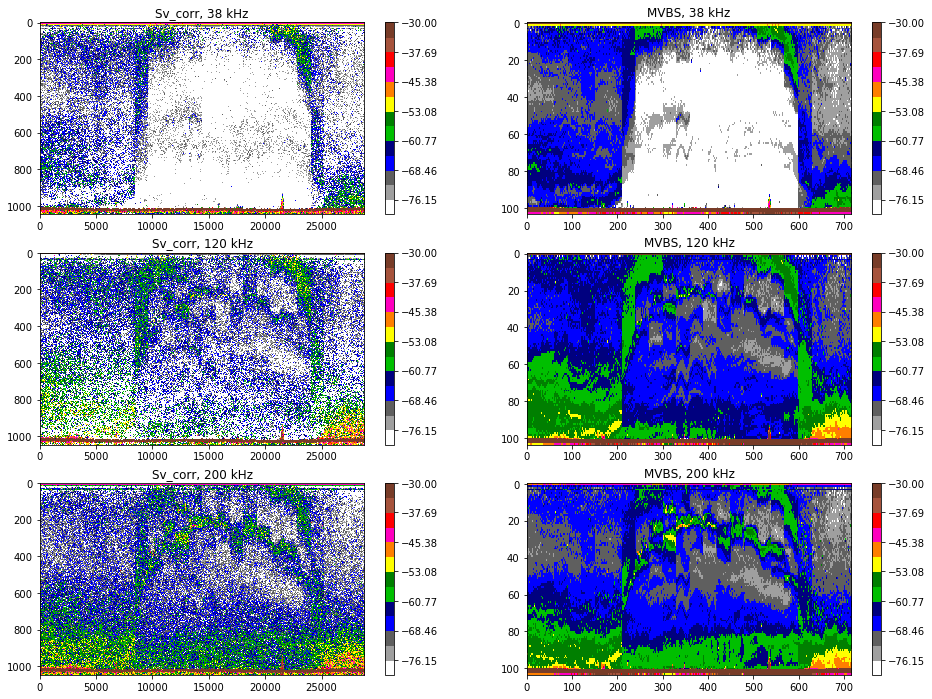

In [534]:
fig,ax = plt.subplots(3,2,figsize=(16,12))
im0 = ax[0,0].imshow(Sv_corr_wanted[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im0,ax=ax[0,0])
ax[0,0].set_title('Sv_corr, 38 kHz')
im1 = ax[0,1].imshow(MVBS[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im1,ax=ax[0,1])
ax[0,1].set_title('MVBS, 38 kHz')
im2 = ax[1,0].imshow(Sv_corr_wanted[1,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im2,ax=ax[1,0])
ax[1,0].set_title('Sv_corr, 120 kHz')
im3 = ax[1,1].imshow(MVBS[1,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im3,ax=ax[1,1])
ax[1,1].set_title('MVBS, 120 kHz')
im4 = ax[2,0].imshow(Sv_raw_wanted[2,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im4,ax=ax[2,0])
ax[2,0].set_title('Sv_corr, 200 kHz')
im5 = ax[2,1].imshow(MVBS[2,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im5,ax=ax[2,1])
ax[2,1].set_title('MVBS, 200 kHz')

In [531]:
MVBS.shape

(3, 104, 717)

## Freq-differencing

In [539]:
Sv_1 = MVBS[2,:,:]
Sv_2 = MVBS[0,:,:]

yes_1 = ~np.isnan(Sv_1)
yes_2 = ~np.isnan(Sv_2)
Sv_diff_12 = Sv_1 - Sv_2
Sv_diff_12[yes_1 & ~yes_2] = np.inf
Sv_diff_12[~yes_1 & yes_2] = -np.inf

idx_fish = (np.isneginf(Sv_diff_12) | (Sv_diff_12<-2)) & (Sv_diff_12>-16)
idx_fish_2 = (np.isneginf(Sv_diff_12) | (Sv_diff_12<-2))
idx_zoop = np.isposinf(Sv_diff_12) | (Sv_diff_12>-2)
idx_other = Sv_diff_12<-16

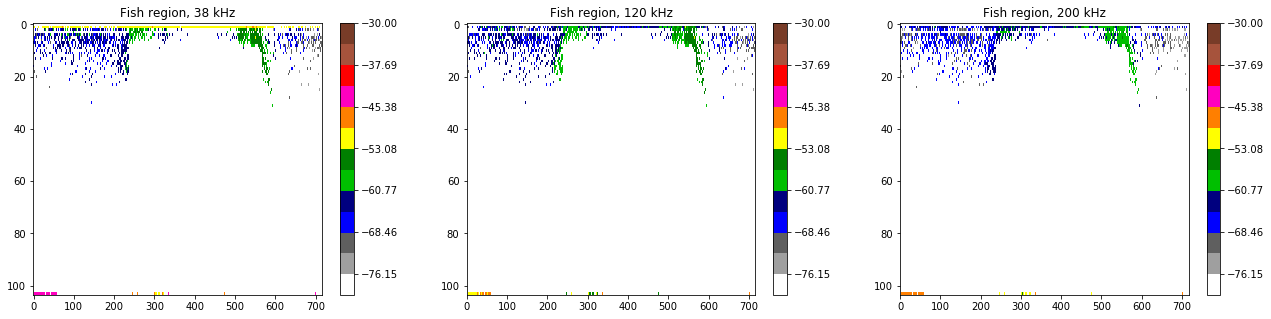

In [545]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(np.ma.masked_where(~idx_fish,MVBS[0,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Fish region, 38 kHz')
im1 = ax1.imshow(np.ma.masked_where(~idx_fish,MVBS[1,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Fish region, 120 kHz')
im2 = ax2.imshow(np.ma.masked_where(~idx_fish,MVBS[2,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Fish region, 200 kHz')

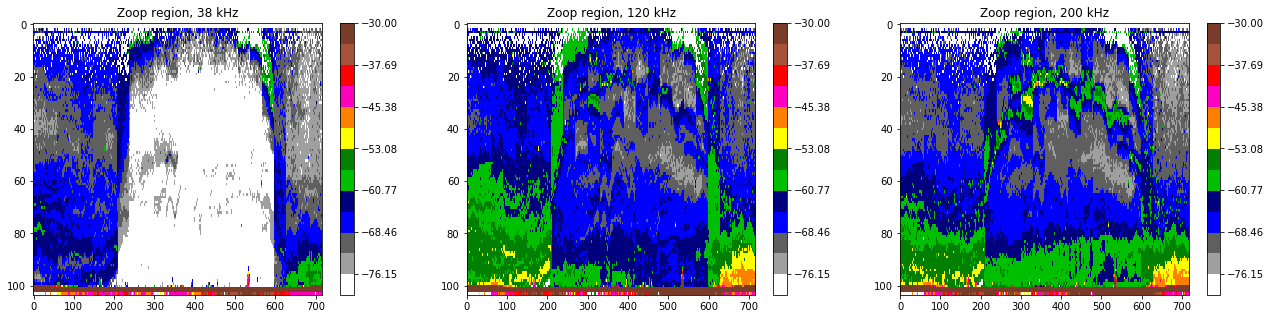

In [543]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(np.ma.masked_where(~idx_zoop,MVBS[0,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Zoop region, 38 kHz')
im1 = ax1.imshow(np.ma.masked_where(~idx_zoop,MVBS[1,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Zoop region, 120 kHz')
im2 = ax2.imshow(np.ma.masked_where(~idx_zoop,MVBS[2,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Zoop region, 200 kHz')